# Heteroscedastic noise modelling demo

When applying Gaussian-process regression to noisy data, we typically need to either specify estimates for the gaussian uncertainty on each data value directly, or specify a model for the noise as part of the covariance kernel. The simplest model for the noise assumes constant variance across all data-points. However if the data contain signficant outliers, these cannot be properly accounted for using a constant noise variance, and this can result in an erroneous regression estimate.

To demonstrate this, we can create some testing data containing both noise and outliers:

In [1]:
from numpy import linspace, sin, log, full
from numpy.random import normal
import matplotlib.pyplot as plt

# construct testing data
n_points = 24
x = linspace(0, 10, n_points)
x_fit = linspace(0, 10, 256)
y_err = full(n_points, fill_value=0.1)
y = sin(x) + normal(scale=y_err, size=n_points)

# modify values at specific points to create outliers
y[n_points // 4] += 2.5
y[-n_points // 5] -= 1.6

Now plot the test data:

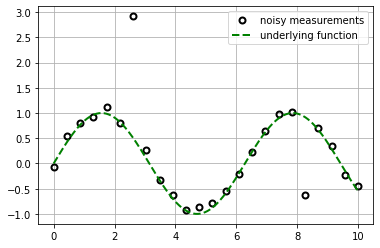

In [2]:
plt.plot(x, y, "o", markerfacecolor="none", c='black', markeredgewidth=2, label="noisy measurements")
plt.plot(x_fit, sin(x_fit), ls='dashed', lw=2, color="green", label="underlying function")
plt.legend()
plt.grid()
plt.show()

First we use GPR to estimate the underlying function using fixed estimates of the uncertainies on each data-point which don't account for the outliers:

In [3]:
from inference.gp import GpRegressor
from inference.covariance import SquaredExponential, WhiteNoise, HeteroscedasticNoise

# build a GP regressor with fixed errors on each data-point
gpr_nk = GpRegressor(
    x=x.reshape([x.size, 1]),
    y=y,
    y_err=y_err,
    kernel=SquaredExponential()
)

# get the regression estimate
mu_nk, sigma_nk = gpr_nk(x_fit)

Now we include the `WhiteNoise` kernel which can add an additional constant noise variance across all data-points:

In [4]:
# build a GP regressor assuming all points have the same noise level
gpr_wn = GpRegressor(
    x=x.reshape([x.size, 1]),
    y=y,
    y_err=y_err,
    kernel=SquaredExponential() + WhiteNoise()
)

# get the regression estimate
mu_wn, sigma_wn = gpr_wn(x_fit)

Finally, using the `HeteroscedasticNoise` kernel, we can obtain a new regression estimate where the noise on each data point is allowed to vary independently:

In [5]:
# build a GP regressor allowing the noise at each point to vary independently
gpr_hn = GpRegressor(
    x=x.reshape([x.size, 1]),
    y=y,
    y_err=y_err,
    kernel=SquaredExponential() + HeteroscedasticNoise()
)

# get the regression estimate
mu_hn, sigma_hn = gpr_hn(x_fit)

Now plot the three different regression estimates:

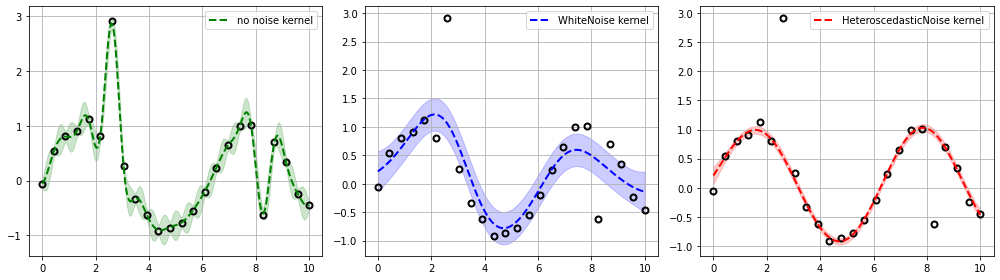

In [6]:
fig = plt.figure(figsize=(14, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.plot(x, y, "o", markerfacecolor="none", c='black', markeredgewidth=2)
ax1.plot(x_fit, mu_nk, "--", c='green', lw=2, label="no noise kernel")
ax1.fill_between(x_fit, mu_nk - sigma_nk, mu_nk + sigma_nk, color='green', alpha=0.2)
ax1.legend()
ax1.grid()

ax2.plot(x, y, "o", markerfacecolor="none", c='black', markeredgewidth=2)
ax2.plot(x_fit, mu_wn, "--", c='blue', lw=2, label="WhiteNoise kernel")
ax2.fill_between(x_fit, mu_wn - sigma_wn, mu_wn + sigma_wn, color='blue', alpha=0.2)
ax2.legend()
ax2.grid()

ax3.plot(x, y, "o", markerfacecolor="none", c='black', markeredgewidth=2)
ax3.plot(x_fit, mu_hn, "--", c='red', lw=2, label="HeteroscedasticNoise kernel")
ax3.fill_between(x_fit, mu_hn - sigma_hn, mu_hn + sigma_hn, color='red', alpha=0.2)
ax3.legend()
ax3.grid()

plt.tight_layout()
plt.show()

The GPR estimate using the `HeteroscedasticNoise` kernel is able to adapt to the outliers by increasing the noise level for those points specifically, resulting in a good estimate of the underlying function.